# Modelling: Predicting Diabetes with NHANES Data

### Author: hl-n

## Overview

This notebook focuses on the training, optimisation, and evaluation of machine learning models for predicting the presence of diabetes using the National Health and Nutrition Examination Survey (NHANES) dataset. We will explore various models, including logistic regression, decision tree, and random forest, to identify the best approach for our predictive task.


## Import Relevant Modules

In [1]:
import os

target_directory = "diabetes-prediction-NHANES"
if not os.path.exists(target_directory):
    os.chdir("..")
    
from src.utils.config_utils import load_config
from src.data_preparation.data_ingestion import load_dataset
from src.data_preparation.data_preprocessing import preprocess_data
from src.data_preparation.data_processing import process_data

from src.ml_models.logistic_regression import LogisticRegressionModel
from src.ml_models.decision_tree import DecisionTreeModel
from src.ml_models.random_forest import RandomForestModel

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve, auc
)

from typing import List
import pandas as pd
import matplotlib.pyplot as plt

## Loading and Processing Raw Data

Before starting the modelling, let's load and process the raw data using the data preparation steps from the EDA.

Let's start by loading the raw dataset using the data ingestion module.<br>
The URL to the raw dataset and the file path to save it to are stored in the config file.

In [2]:
config = load_config(config_path="config.yaml")
df = load_dataset(
    file_path=config.get("raw_dataset_path"),
    url=config.get("raw_dataset_url")
)
df # Preview the DataFrame

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,62155,male,33.000000,Mexican American,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97
6791,62156,female,48.916667,Non-Hispanic White,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89
6792,62157,male,27.500000,Other Hispanic,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94
6793,62158,male,75.750000,Non-Hispanic Black,"[10000,15000)",0,0,75.1,162.7,28.37,38.6,36.8,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34


Let's process the raw data.

In [3]:
df = preprocess_data(df, config)
df

,Sex,Age ($years$),Race/Ethnicity,Family Income,On Insulin or Diabetes Meds,Diagnosed with DM or Pre-DM,Weight ($kg$),Standing Height ($cm$),Body Mass Index ($kg/m^2$),Upper Leg Length ($cm$),Upper Arm Length ($cm$),Arm Circumference ($cm$),Waist Circumference ($cm$),Triceps Skinfold ($mm$),Subscapular Skinfold ($mm$),Glycohemoglobin ($\%$),Albumin ($g/dL$),Blood urea nitrogen ($mg/dL$),Creatinine ($mg/dL$)
Respondent sequence number,,,,,,,,,,,,,,,,,,,
51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62155,male,33.000000,Mexican American,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97
62156,female,48.916667,Non-Hispanic White,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89
62157,male,27.500000,Other Hispanic,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94


In [4]:
X_train, X_test, y_train, y_test = process_data(df, config)
X_train

,Age ($years$),Albumin ($g/dL$),Arm Circumference ($cm$),Blood urea nitrogen ($mg/dL$),Body Mass Index ($kg/m^2$),Creatinine ($mg/dL$),Diagnosed with DM or Pre-DM,Is Female,Maximum Family Income,Minimum Family Income,...,Triceps Skinfold ($mm$),Upper Arm Length ($cm$),Upper Leg Length ($cm$),Waist Circumference ($cm$),Weight ($kg$),Race/Ethnicity_Mexican American,Race/Ethnicity_Non-Hispanic Black,Race/Ethnicity_Non-Hispanic White,Race/Ethnicity_Other Hispanic,Race/Ethnicity_Other Race Including Multi-Racial
0,-1.384926,-1.266592,-0.760619,-1.770918,-0.488714,-0.255250,False,True,1.701883,1.035137,...,-0.697723,0.825121,0.677602,-0.978125,0.061546,False,True,False,False,False
1,1.491652,-0.057992,-1.301302,1.461408,-1.140620,1.872336,True,True,0.926057,0.588418,...,-0.426469,-1.238835,-1.152193,-0.263706,-1.551099,False,False,True,False,False
2,0.984774,0.591286,-0.577381,0.422433,-0.870617,1.544827,False,False,1.701883,1.035137,...,-1.607235,-0.444865,-0.135356,-1.085580,-0.906425,False,True,False,False,False
3,0.937224,0.262868,0.581659,-0.449463,0.813834,-1.096428,True,True,-1.457919,-1.423137,...,1.980656,-1.238835,-1.621814,0.457524,-0.222658,True,False,False,False,False
4,-0.525230,-1.266592,-0.876368,-0.723031,-0.641650,-1.235748,False,True,1.701883,1.035137,...,0.182443,-1.587157,-0.315973,-1.147643,-1.052610,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6375,1.500788,-0.975594,0.821778,1.068532,1.246194,-0.410781,True,True,0.926057,0.588418,...,1.473498,-0.459195,-2.024537,1.354941,0.663410,True,False,False,False,False
6376,1.073164,-0.699368,1.336452,1.432204,0.874762,-1.045980,False,True,-0.463633,-0.515147,...,1.980543,-0.410447,-1.244422,0.841637,0.364691,True,False,False,False,False
6377,1.123269,-0.020977,-0.270883,1.271522,0.109441,-0.454829,True,True,-0.020848,-0.311320,...,0.576943,-0.597214,-1.222083,0.196295,-0.402630,False,False,True,False,False
6378,0.619176,-2.060460,-0.832495,-0.762850,-0.409867,-0.554289,True,True,-0.020848,-0.311320,...,-0.002034,-0.646296,-0.944609,-0.042501,-0.768856,True,False,False,False,False


## Modelling Processed Data

Now that we have processed the raw data, we can move on to the modelling phase to develop and evaluate our machine learning models for predicting diabetes.<br>
We'll start by implementing baseline machine learning models—logistic regression, decision tree, and random forest—with default hyperparameters.<br>
The focus is on establishing initial models for further optimisation and analysis.

LogisticRegressionModel

Accuracy: 0.95
Precision: 0.64
Recall: 0.86
PR-AUC Score: 0.61
ROC-AUC Score: 0.94

Confusion Matrix:
[[768  37]
 [ 11  65]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.97       805
        True       0.64      0.86      0.73        76

    accuracy                           0.95       881
   macro avg       0.81      0.90      0.85       881
weighted avg       0.96      0.95      0.95       881

                                             Feature  Importance
6                        Diagnosed with DM or Pre-DM    0.741323
10                       On Insulin or Diabetes Meds    0.496031
18                   Race/Ethnicity_Mexican American    0.212589
21                     Race/Ethnicity_Other Hispanic    0.200449
12                       Subscapular Skinfold ($mm$)    0.158009
16                        Waist Circumference ($cm$)    0.143826
1                                   Albumin (

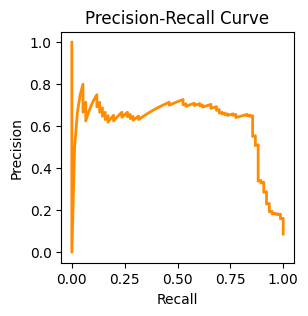


DecisionTreeModel

Accuracy: 0.91
Precision: 0.48
Recall: 0.61
PR-AUC Score: 0.56
ROC-AUC Score: 0.77

Confusion Matrix:
[[756  49]
 [ 30  46]]
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.94      0.95       805
        True       0.48      0.61      0.54        76

    accuracy                           0.91       881
   macro avg       0.72      0.77      0.74       881
weighted avg       0.92      0.91      0.91       881

                                             Feature  Importance
6                        Diagnosed with DM or Pre-DM    0.996544
4                         Body Mass Index ($kg/m^2$)    0.032956
1                                   Albumin ($g/dL$)    0.031539
14                           Upper Arm Length ($cm$)    0.026899
11                            Standing Height ($cm$)    0.025896
15                           Upper Leg Length ($cm$)    0.022464
5                               Creatinine ($mg/dL

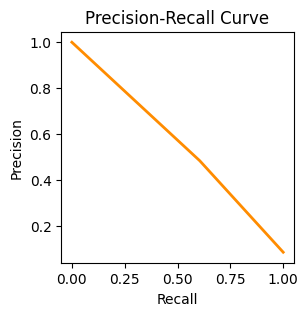


RandomForestModel

Accuracy: 0.95
Precision: 0.69
Recall: 0.76
PR-AUC Score: 0.64
ROC-AUC Score: 0.94

Confusion Matrix:
[[779  26]
 [ 18  58]]
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       805
        True       0.69      0.76      0.72        76

    accuracy                           0.95       881
   macro avg       0.83      0.87      0.85       881
weighted avg       0.95      0.95      0.95       881

                                             Feature  Importance
6                        Diagnosed with DM or Pre-DM    0.710755
10                       On Insulin or Diabetes Meds    0.643010
0                                      Age ($years$)    0.190880
16                        Waist Circumference ($cm$)    0.117809
12                       Subscapular Skinfold ($mm$)    0.081194
1                                   Albumin ($g/dL$)    0.063851
4                         Body Mass Index ($kg/m^2

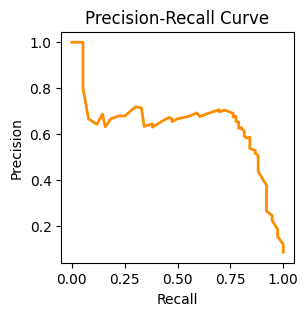

In [5]:
random_state = config.get("random_state")
models = [
    LogisticRegressionModel(
        random_state=random_state,
    ),
    DecisionTreeModel(
        random_state=random_state,
    ),
    RandomForestModel(
        random_state=random_state,
    )
]
for model in models:
    print(f"{model.__class__.__name__}\n")
    model.train(X_train, y_train)    
    model.evaluate(X_test, y_test)
    print()

**Evaluation Metrics:**

Prioritise key metrics such as precision, recall, F1 score, and the area under the precision-recall curve (PR-AUC) to gain a nuanced understanding of model performance, particularly in the context of the imbalanced dataset.

**Logistic Regression and Random Forest Models:**

Both models exhibit moderately high precision, recall, and F1-scores, providing a balanced performance across multiple metrics.

**Decision Tree Model:**

While offering interpretability, the Decision Tree model lags slightly behind in overall performance compared to Logistic Regression and Random Forest.

**Influential Features:**

Common variables contributing to model predictions include factors related to diabetes diagnosis, age, and various anthropometric measurements.

**Considerations:**

When choosing the best model, we should carefully weigh interpretability against the nuanced trade-off between precision and recall.<br>
This decision should align with clinical priorities and the specific goals of the predictive model.
